## Data Description  

- Write the data description details here
-

## Importing Libraries 

In [1]:
import scipy.io
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from utils import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
os.chdir(os.path.dirname(os.getcwd()))

# Scenario 1

In this section we wil prepare the data for the scneario of **Single Sensor 11 Classes**. The steps of pre-processsing will be as follows: 
<ol>
  <li> Load the data from excel files.</li>
  <li> Arrange the data into healthy class and ten damaged classses.</li>
  <li> Remove the time column as it is affecting the performance.</li>
  <li> Apply sliding window on the data from each class to get the smaller sample length that can fit the model training.</li>
  <li> Split the data intor train and test with 90/10 percentage for training and testing respectviely.</li>
  <li> save the data in .pt file to be loaded during model trainig </li>
</ol>

###  Step 1: Data Loading
The data strucutre and detailes can be summarized as follows: 
- 11 excel files are avaiable with, 10 damaged files and single healthy files. 
- Each damage file is corresponding the damage in each level (e.g., D1 is corresponding to damage in level 1).
- Each excel file contains two columns (i.e., time, acceleration data). 
- The length of each accelearation signal is 256000 data points. 

##### a- Loading Data from excel files

In [9]:
data_dir = os.path.join(os.getcwd(),'Structural Health Monitring','data')
D1=pd.read_excel(os.path.join(data_dir,'D1_1.xlsx'))
D2=pd.read_excel(os.path.join(data_dir,'D2_1.xlsx'))
D3=pd.read_excel(os.path.join(data_dir,'D3_1.xlsx'))
D4=pd.read_excel(os.path.join(data_dir,'D4_1.xlsx'))
D5=pd.read_excel(os.path.join(data_dir,'D5_1.xlsx'))
D6=pd.read_excel(os.path.join(data_dir,'D6_1.xlsx'))
D7=pd.read_excel(os.path.join(data_dir,'D7_1.xlsx'))
D8=pd.read_excel(os.path.join(data_dir,'D8_1.xlsx'))
D9=pd.read_excel(os.path.join(data_dir,'D9_1.xlsx'))
D10=pd.read_excel(os.path.join(data_dir,'D10_1.xlsx'))
U1=pd.read_excel(os.path.join(data_dir,'U1_1.xlsx'))

##### b- Extracting damaged and healthy data and concatenate them into single file 
In this step we concaeante data from different files into single excel file.

In [36]:
#Concatenate all the data together
dataset= [U1,D1,D2, D3,D4,D5,D6,D7,D8,D9,D10]
dataset= pd.concat(dataset,sort =True,axis =1)
# drop_time from all columns 
col_name=D1.columns[0]
dataset=dataset.drop(col_name, axis=1)
#rename Columns
dataset.columns=['Healthy','D1','D2','D3','D4','D5','D6','D7', 'D8','D9','D10']
#Insert time column in the begining 
full_data =[D1[col_name], dataset]
full_data =pd.concat(full_data, axis =1)
full_data.to_csv(os.path.join(data_dir,' full_data.csv'))
# print the data dimension and show sample from the file
print(dataset.shape)
full_data.head()

##### c- Use sliding window to segment the 256000 data point into shorter samples to be fit the model training 

In [21]:
# initialize train data and labels
num_classes= 11 
# number of samples per each class
num_samples = 250 
# The sample length for each class
sample_len =1024 
# Empty tensor to store the data 
torch_dataset = torch.zeros(num_classes,num_samples,sample_len)
# class index 
class_id = 0
# Initial tensor for the labels
data_labels = torch.LongTensor(num_classes,num_samples,1)
for (columnName, columnData) in dataset.iteritems():
    # apply sliding window function to each column in the data (data column, sample length, shifting step )
    # if the sample length equal to shifting step it means there is no overlap among the data.
    torch_dataset[class_id] =  torch.from_numpy(sliding_window(columnData.values , sample_len,sample_len, 'T')) 
    data_labels[class_id] = class_id 
    class_id+=1
acceleration_data=torch_dataset.view(-1, sample_len)
labels = data_labels.view(-1)

##### d- Use sliding window to segment the 256000 data point into shorter samples to be fit the model training 

In [22]:
# Split the data wuth 90% training and 10%
train_size = int(0.9 * len(acceleration_data))
test_size = len(acceleration_data) - train_size
train_idx, test_idx = torch.utils.data.random_split(np.arange(len(acceleration_data)), [train_size, test_size])
train_data = acceleration_data[train_idx]
train_labels = labels[train_idx]
test_data = acceleration_data[test_idx]
test_labels = labels[test_idx]
print(f'train_data_size: {train_data.shape}')
print(f'test_data_size: {test_data.shape}')

##### e- Save the data files 

In [24]:
acceleration_dataset ={'train_data':train_data,'train_labels':train_labels, 'test_data':test_data,'test_labels':test_labels}
torch.save(acceleration_dataset,os.path.join(data_dir,'train_test_dataset_512_90.pt'))
train_dl = DataLoader(MyDataset(train_data, train_labels), batch_size=256, shuffle=True, drop_last=False)
test_dl = DataLoader(MyDataset(test_data, test_labels), batch_size=10, shuffle=False, drop_last=False)

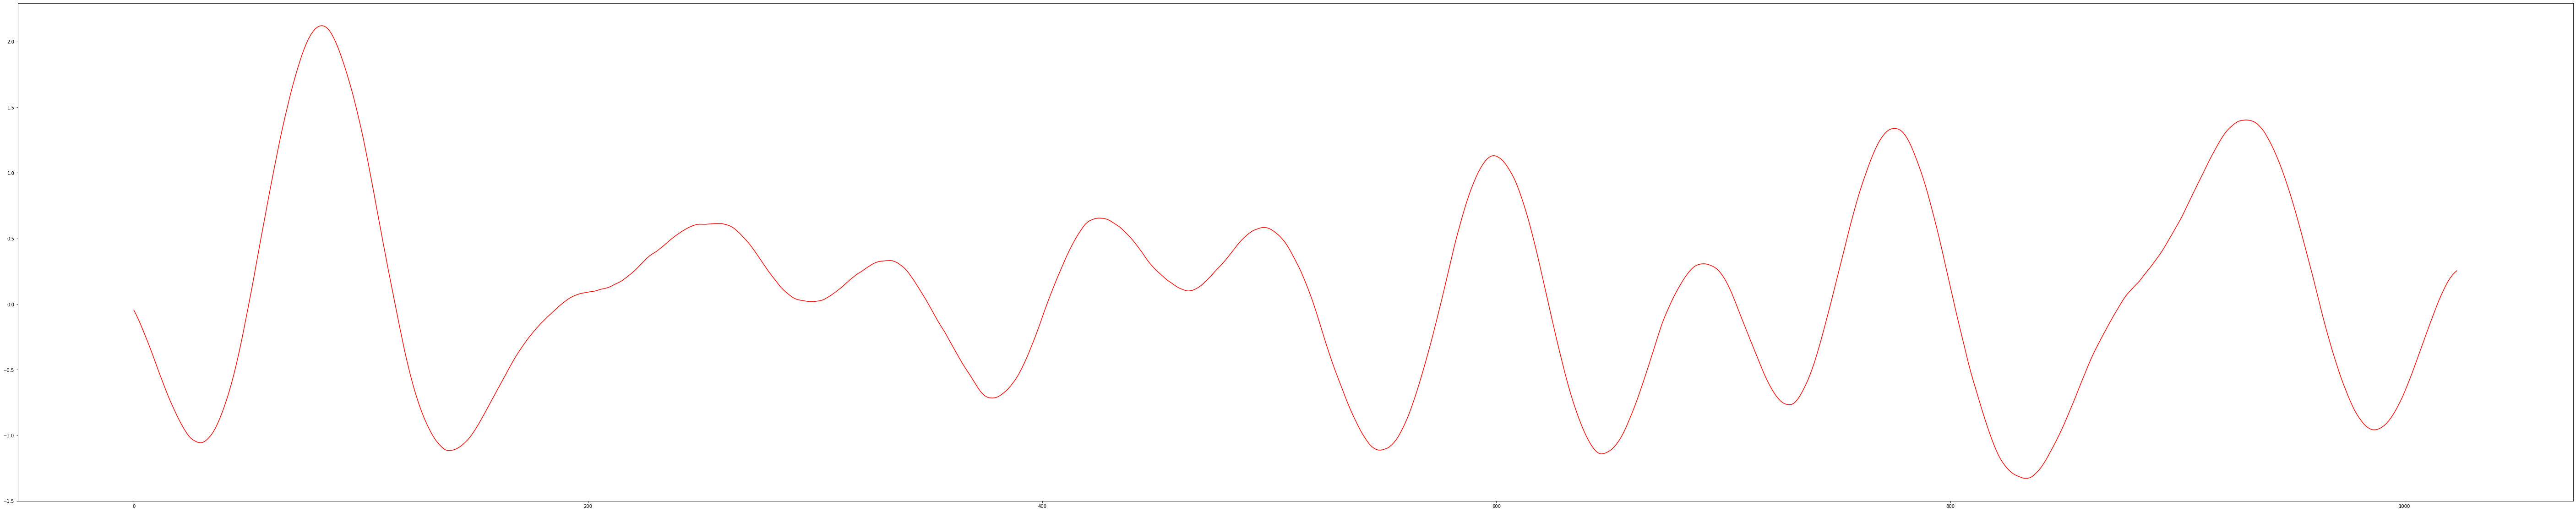

In [15]:
data, label= iter(train_dl).next()
# Visualize the timeseries data
visualizeTimeseriesSensorData(data[9],0,sample_len)

# 1 Sensors 2 Classes Scenario 

In [18]:
Damaged= [D1,D2, D3,D4,D5,D6,D7,D8,D9,D10]
Damaged= pd.concat(Damaged,sort =True,axis =1)
# drop_time from all columns 
col_name=D1.columns[0]
Damaged=Damaged.drop(col_name, axis=1)
#rename Columns
Damaged.columns=['D1','D2','D3','D4','D5','D6','D7', 'D8','D9','D10']
print(Damaged.shape)
Damaged.head()

(256000, 10)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
0,0.000000,-2.461236e-20,-5.107184e-21,1.313745e-22,-7.439058e-21,0.000000,0.000000,-1.488389e-20,-5.351401e-22,0.000000
1,-0.000996,8.344572e-05,2.188426e-04,-1.255045e-03,-1.954813e-05,-0.001223,0.000066,2.829642e-04,-5.121637e-05,0.000602
2,-0.001850,-1.638214e-04,8.660839e-04,-4.695261e-03,1.817016e-03,-0.004737,0.001772,1.889366e-03,1.987464e-04,0.001614
3,-0.002096,-3.207972e-04,3.057657e-04,-8.494026e-03,4.000488e-03,-0.009943,0.004677,3.155695e-03,2.128201e-03,0.001152
4,-0.002127,-1.246590e-04,-3.983221e-04,-1.154697e-02,5.430322e-03,-0.016550,0.007071,4.042560e-03,5.307392e-03,0.000378


In [25]:
Healthy =U1
Healthy = Healthy.drop('Time (s)',axis=1)
Healthy.columns=['Healthy']
print(Healthy.shape)
Healthy.head()

(256000, 1)


,Healthy
0,-3.532606e-20
1,1.081126e-03
2,3.520905e-03
3,4.005363e-03
4,5.169354e-03


## Sliding Window for Healthy Data 

In [28]:
# initialize train data and labels
num_cols = 1
num_samples = 250 
sample_len =1024 
torch_dataset = torch.zeros(num_cols,num_samples,sample_len)
class_label = 0
column_index = 0
data_labels = torch.LongTensor(num_cols, num_samples)
for (columnName, columnData) in Healthy.iteritems():
    torch_dataset[column_index] =  torch.from_numpy(sliding_window(columnData.values , sample_len,sample_len, 'T')) 
    data_labels[column_index] = class_label 
    column_index+=1 
healthy_data=torch_dataset.view(-1, sample_len)
healthy_labels = data_labels.view(-1)
print(' Healthy Data : ', healthy_data.shape)
print(' Healthy Labels :', healthy_labels.shape)

 Healthy Data :  torch.Size([250, 1024])
 Healthy Labels : torch.Size([250])


## Sliding Window for Damaged Data 

In [29]:
# initialize train data and labels
num_cols = 10
num_samples = 250 
sample_len =1024 
torch_dataset = torch.zeros(num_cols,num_samples,sample_len)
class_label = 1
column_index = 0
data_labels = torch.LongTensor(num_cols, num_samples)
for (columnName, columnData) in Damaged.iteritems():
    torch_dataset[column_index] =  torch.from_numpy(sliding_window(columnData.values , sample_len,sample_len, 'T')) 
    data_labels[column_index] = class_label 
    column_index+=1
    
damaged_data=torch_dataset.view(-1, sample_len)
damaged_labels = data_labels.view(-1)
print('Damaged Data : ', damaged_data.shape)
print('Damaged Labels :', damaged_labels.shape)

Damaged Data :  torch.Size([2500, 1024])
Damaged Labels : torch.Size([2500])


In [30]:
# Spltting for Healthy
train_size = int(0.9 * len(healthy_data))
test_size = len(healthy_data) - train_size
train_idx, test_idx = torch.utils.data.random_split(np.arange(len(healthy_data)), [train_size, test_size])
train_data_h = healthy_data[train_idx]
train_labels_h = healthy_labels[train_idx]
test_data_h = healthy_data[test_idx]
test_labels_h = healthy_labels[test_idx]
print(f'train_data_size: {train_data_h.shape}')
print(f'test_data_size: {test_data_h.shape}')

train_data_size: torch.Size([225, 1024])
test_data_size: torch.Size([25, 1024])


In [31]:
# Spltting for damaged
train_size = int(0.9 * len(damaged_data))
test_size = len(damaged_data) - train_size
train_idx, test_idx = torch.utils.data.random_split(np.arange(len(damaged_data)), [train_size, test_size])
train_data_d = damaged_data[train_idx]
train_labels_d = damaged_labels[train_idx]
test_data_d = damaged_data[test_idx]
test_labels_d = damaged_labels[test_idx]
print(f'train_data_size: {train_data_d.shape}')
print(f'test_data_size: {test_data_d.shape}')


train_data_size: torch.Size([2250, 1024])
test_data_size: torch.Size([250, 1024])


In [32]:
# Concateante healthy and damaged data into one file
train_data = torch.cat((train_data_h,train_data_d))
train_labels = torch.cat((train_labels_h, train_labels_d))
test_data = torch.cat((test_data_h, test_data_d))
test_labels =torch.cat((test_labels_h,test_labels_d))
print(f'train_data_size: {train_data.shape}')
print(f'test_data_size: {test_data.shape}')
# Full Dataset approach
print(f'train_data_size: {train_data.shape}')
print(f'test_data_size: {test_data.shape}')

train_data_size: torch.Size([2475, 1024])
test_data_size: torch.Size([275, 1024])
train_data_size: torch.Size([2475, 1024])
test_data_size: torch.Size([275, 1024])


In [33]:
# Saving the data
dataset_1s_11_class ={'train_data':train_data,'train_labels':train_labels, 'test_data':test_data,'test_labels':test_labels}

torch.save(dataset_1s_11_class,os.path.join(data_dir,'train_test_dataset_1s_11_class.pt'))

# DL model

In [52]:
import torch.nn as nn 
from models.models_config import get_model_config, initlize
from pre_train_test_split import trainer
device = torch.device('cuda')

class CNN_1D(nn.Module):
    def __init__(self, input_dim, hidden_dim,dropout):
        super(CNN_1D, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.dropout=dropout
        self.encoder = nn.Sequential(
            nn.Conv1d(self.input_dim, 8, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.Flatten(),
            nn.Linear(8, self.hidden_dim)) 
        self.Classifier= nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),   
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(self.hidden_dim, self.hidden_dim//2) ,  
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(self.hidden_dim//2, 11))    
    def forward(self, src):
        features = self.encoder(src)
        predictions = self.Classifier(features)
        return predictions, features

model=CNN_1D(1,32,0.5).to(device)


params = {'window_length': 30, 'sequence_length': 30, 'batch_size': 10, 'input_dim': 14, 'pretrain_epoch': 40,
          'data_path': r"C:/Users/mohamedr002/OneDrive - Nanyang Technological University/PhD Codes Implementation/Deep Learning for RUL/data/processed_data/cmapps_train_test_cross_domain.pt",
          'dropout': 0.5,  'lr': 1e-4}
# load model
config = get_model_config('CNN')
# load data  
trained_model=trainer(model, train_dl, test_dl,'SHM' ,config,params)